# 1-S1: ML 개념 + Sklearn

머신러닝의 기초 개념과 Sklearn 사용법을 학습합니다.

## 학습 목표
1. ML이란? (규칙 기반 vs ML, 분류 vs 회귀)
2. 과적합과 train/test 분할
3. fit → predict 패턴
4. 평가 지표 (Accuracy, Recall, Precision, AUC)
5. 트리 모델 비교 (Decision Tree, Random Forest, XGBoost)

In [112]:
!pip install -q seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 임포트 완료")

패키지 임포트 완료


## 실습 데이터: Credit Card Fraud Detection

이 노트북에서는 **Kaggle Credit Card Fraud Detection** 데이터셋을 사용합니다.

**데이터 설명:**
- 284,807건의 신용카드 거래 데이터 (유럽, 2013년 9월)
- **V1~V28**: PCA로 변환된 익명 특성 (개인정보 보호)
- **Amount**: 거래 금액
- **Time**: 첫 거래 이후 경과 시간(초)
- **Class**: 사기 여부 (0=정상, 1=사기)

**특징:**
- 실제 사기 패턴이 포함된 데이터
- 극심한 불균형: 사기 0.17% (492건 / 284,807건)
- 더미 데이터와 달리 **모델 효과를 실제로 체감** 가능

In [113]:
# 📚 Credit Card Fraud 데이터 로드 (전체 사용)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드 (전체 28만건)
df = pd.read_csv('../../../data/raw/creditcard.csv')

print(f"전체 데이터: {len(df):,}건")
print(f"사기 거래: {df['Class'].sum():,}건 ({df['Class'].mean():.2%})")
print(f"정상:사기 비율 = {len(df[df['Class']==0]):,}:{len(df[df['Class']==1]):,} (약 {len(df[df['Class']==0])//len(df[df['Class']==1])}:1)")

# 특성과 타겟 분리
# V1~V14 + Amount 사용
feature_cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                'V11', 'V12', 'V13', 'V14', 'Amount']
X = df[feature_cols]
y = df['Class']

# train/test 분할 (stratify로 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 클래스 불균형 가중치 계산 (XGBoost용)
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

print(f"Train: {len(X_train):,}건, Test: {len(X_test):,}건")
print(f"사기 비율: {y_train.mean():.2%}")
print(f"scale_pos_weight: {scale_pos_weight:.1f} 불균형 보정용")

전체 데이터: 284,807건
사기 거래: 492건 (0.17%)
정상:사기 비율 = 284,315:492 (약 577:1)
Train: 227,845건, Test: 56,962건
사기 비율: 0.17%
scale_pos_weight: 577.3 불균형 보정용


---
## 1. ML이란?

### 1-1. 왜 ML을 쓰는가?

**규칙 기반 시스템의 한계**

전통적인 프로그래밍은 **규칙을 직접 작성**합니다:
- "금액이 100만원 이상이면 사기"
- "새벽 3시에 거래하면 사기"
- "해외에서 결제하면 사기"

**문제점:**
1. 규칙을 일일이 만들어야 함
2. 새로운 패턴이 나타나면 규칙 추가 필요
3. 규칙 간 충돌 발생 ("100만원 해외결제는 사기? 정상?")
4. 복잡한 패턴 표현 어려움

**ML의 장점:**
- 데이터에서 **자동으로 패턴 학습**
- 여러 특성을 **조합**해서 판단
- 새 데이터로 **업데이트** 가능

In [4]:
# 📚 규칙 기반 vs ML 비교

# 1. 규칙 기반: 직접 규칙 작성
def rule_based_detect(amount, hour, is_foreign):
    """
    규칙 기반 사기 탐지
    - 100만원 이상이면 사기
    - 새벽(0~5시)이면 사기
    - 해외결제면 사기
    """
    if amount > 1000000:
        return 1  # 사기
    if 0 <= hour <= 5:
        return 1  # 사기
    if is_foreign == 1:
        return 1  # 사기
    return 0  # 정상

# 테스트 케이스
test_cases = [
    (50000, 14, 0, "50만원, 오후 2시, 국내"),      # 정상인데 정상 → OK
    (2000000, 14, 0, "200만원, 오후 2시, 국내"),   # 정상인데 사기 → 오탐
    (30000, 3, 0, "3만원, 새벽 3시, 국내"),        # 정상인데 사기 → 오탐  
    (500000, 14, 0, "50만원 사기"),                # 사기인데 정상 → 놓침!
]

print("규칙 기반 결과:")
print("-" * 50)
for amount, hour, is_foreign, desc in test_cases:
    result = rule_based_detect(amount, hour, is_foreign)
    print(f"{desc}: {'사기' if result else '정상'}")

print()
print("문제점:")
print("  - 50만원짜리 사기는 못 잡음 (규칙: 100만원 이상만)")
print("  - 새벽에 정상 거래해도 사기로 판단")
print("  - 규칙 추가할수록 복잡해짐")

규칙 기반 결과:
--------------------------------------------------
50만원, 오후 2시, 국내: 정상
200만원, 오후 2시, 국내: 사기
3만원, 새벽 3시, 국내: 사기
50만원 사기: 정상

문제점:
  - 50만원짜리 사기는 못 잡음 (규칙: 100만원 이상만)
  - 새벽에 정상 거래해도 사기로 판단
  - 규칙 추가할수록 복잡해짐


In [5]:
# 📚 ML은 어떻게 다른가?

# ML: 데이터에서 패턴을 학습
# (아직 실제 ML 코드는 아님, 개념 설명용)

print("ML의 접근법:")
print("="*50)
print()
print("1. 데이터 준비")
print("   - 과거 거래 데이터 수집")
print("   - 각 거래가 사기인지 정상인지 라벨링")
print()
print("2. 모델 학습")
print("   - ML 모델에 데이터를 넣으면")
print("   - 자동으로 '사기 패턴'을 찾음")
print("   - 예: 금액 높음 + 새벽 + 해외 → 사기 확률 높음")
print()
print("3. 예측")
print("   - 새로운 거래가 들어오면")
print("   - 학습된 패턴으로 사기 여부 예측")
print()
print("장점: 규칙을 직접 안 만들어도 됨!")

ML의 접근법:

1. 데이터 준비
   - 과거 거래 데이터 수집
   - 각 거래가 사기인지 정상인지 라벨링

2. 모델 학습
   - ML 모델에 데이터를 넣으면
   - 자동으로 '사기 패턴'을 찾음
   - 예: 금액 높음 + 새벽 + 해외 → 사기 확률 높음

3. 예측
   - 새로운 거래가 들어오면
   - 학습된 패턴으로 사기 여부 예측

장점: 규칙을 직접 안 만들어도 됨!


### 1-2. 분류 vs 회귀

ML 문제는 크게 **분류(Classification)**와 **회귀(Regression)**로 나뉩니다.

| 유형 | 출력 | 예시 |
|------|------|------|
| **분류** | 카테고리 (0/1, A/B/C) | 사기 탐지, 스팸 분류, 질병 진단 |
| **회귀** | 연속적인 숫자 | 집값 예측, 매출 예측, 온도 예측 |

**FDS(이상거래탐지)는 분류 문제입니다:**
- 입력: 거래 정보 (금액, 시간, 위치 등)
- 출력: 사기(1) 또는 정상(0)
- 이것을 **이진 분류(Binary Classification)**라고 합니다

In [6]:
# 📚 분류 vs 회귀 예시

print("분류 (Classification) 예시:")
print("-" * 40)
print("입력: 이메일 내용")
print("출력: 스팸(1) / 정상(0)")
print()
print("입력: 거래 정보")
print("출력: 사기(1) / 정상(0)  ← FDS!")
print()
print("입력: 환자 검사 결과")
print("출력: 암(1) / 정상(0)")
print()

print("회귀 (Regression) 예시:")
print("-" * 40)
print("입력: 집 정보 (면적, 위치, 층수)")
print("출력: 집값 (3억 5천만원)")
print()
print("입력: 과거 매출 데이터")
print("출력: 다음 달 매출 (1억 2천만원)")

분류 (Classification) 예시:
----------------------------------------
입력: 이메일 내용
출력: 스팸(1) / 정상(0)

입력: 거래 정보
출력: 사기(1) / 정상(0)  ← FDS!

입력: 환자 검사 결과
출력: 암(1) / 정상(0)

회귀 (Regression) 예시:
----------------------------------------
입력: 집 정보 (면적, 위치, 층수)
출력: 집값 (3억 5천만원)

입력: 과거 매출 데이터
출력: 다음 달 매출 (1억 2천만원)


---
## 2. 과적합과 데이터 분할

### 2-1. 과적합(Overfitting)이란?

**시험공부 비유:**

- 기출문제만 달달 외우면?
  - 기출문제: 100점
  - 새로운 문제: 0점
  
- 개념을 이해하면?
  - 기출문제: 90점
  - 새로운 문제: 85점

**ML에서도 마찬가지:**

- 과적합된 모델:
  - 학습 데이터: 정확도 100%
  - 새 데이터: 정확도 50% (쓸모없음)
  
- 좋은 모델:
  - 학습 데이터: 정확도 90%
  - 새 데이터: 정확도 85% (실제로 유용함)

**그래서 train/test를 나눕니다:**
- Train 데이터: 모델 학습용
- Test 데이터: 성능 평가용 (모델이 못 본 데이터)

깊이별 학습: 100%|█| 20/20 [01:10<00:00,  3.51s/it]

완료: 70.1초
최적 깊이: 4 (Test 정확도: 0.9994)


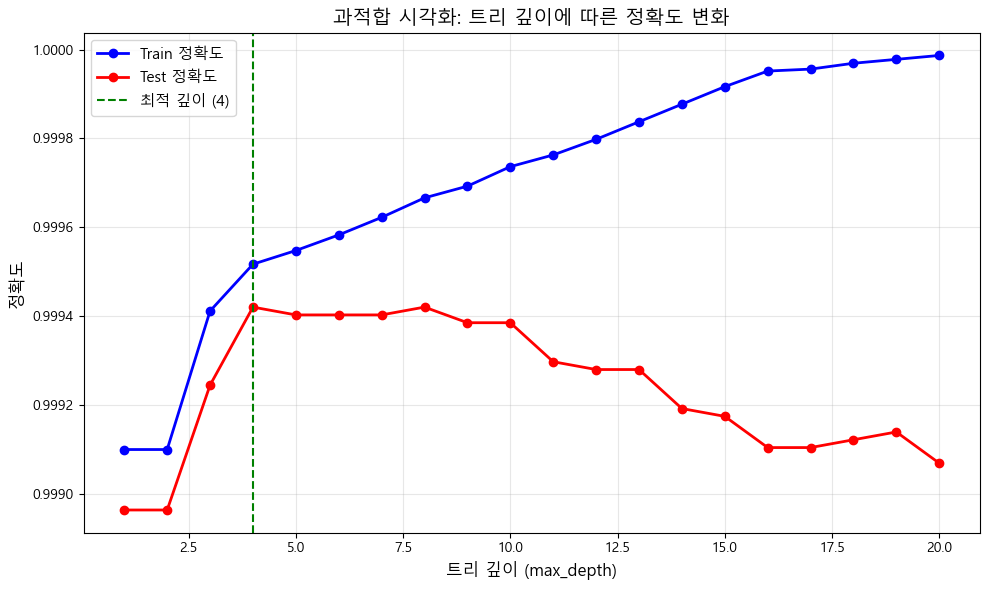


해석:
- 깊이 4까지는 Test 정확도 상승
- 그 이후로는 Train만 올라가고 Test는 정체/하락 → 과적합!


In [114]:
# 📚 과적합 시각화
import time
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

start = time.time()

# 다양한 깊이로 테스트
depths = range(1, 21)
train_scores = []
test_scores = []

for depth in tqdm(depths, desc="깊이별 학습"):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

print(f"완료: {time.time() - start:.1f}초")

# 최적 깊이 찾기 (Test 정확도 최대)
best_depth = depths[np.argmax(test_scores)]
best_score = max(test_scores)
print(f"최적 깊이: {best_depth} (Test 정확도: {best_score:.4f})")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, 'b-o', label='Train 정확도', linewidth=2)
plt.plot(depths, test_scores, 'r-o', label='Test 정확도', linewidth=2)
plt.axvline(x=best_depth, color='green', linestyle='--', label=f'최적 깊이 ({best_depth})')

plt.xlabel('트리 깊이 (max_depth)', fontsize=12)
plt.ylabel('정확도', fontsize=12)
plt.title('과적합 시각화: 트리 깊이에 따른 정확도 변화', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n해석:")
print(f"- 깊이 {best_depth}까지는 Test 정확도 상승")
print(f"- 그 이후로는 Train만 올라가고 Test는 정체/하락 → 과적합!")

### 2-2. train_test_split 상세 설명

`train_test_split`은 데이터를 학습용과 테스트용으로 나누는 함수입니다.

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,              # 특성 데이터 (입력)
    y,              # 타겟 데이터 (정답)
    test_size=0.2,  # 테스트 비율 (20%)
    random_state=42 # 랜덤 시드 (재현성)
)
```

**파라미터 설명:**
| 파라미터 | 설명 | 예시 |
|----------|------|------|
| `X` | 특성(feature) 데이터. 모델의 입력 | 금액, 시간, 해외여부 |
| `y` | 타겟(label) 데이터. 정답 | 사기(1) / 정상(0) |
| `test_size` | 테스트셋 비율 | 0.2 = 20% |
| `random_state` | 랜덤 시드. 같은 값이면 같은 결과 | 42 (아무 숫자) |

**반환값:**
| 반환값 | 설명 |
|--------|------|
| `X_train` | 학습용 특성 (80%) |
| `X_test` | 테스트용 특성 (20%) |
| `y_train` | 학습용 정답 (80%) |
| `y_test` | 테스트용 정답 (20%) |

In [115]:
# 📚 데이터 확인 (위에서 이미 로드함)

print("데이터 샘플:")
print(df[['V1', 'V2', 'V3', 'Amount', 'Class']].head())
print(f"\n전체 데이터: {len(df)}건")
print(f"사기 비율: {df['Class'].mean():.2%}")

데이터 샘플:
         V1        V2        V3  Amount  Class
0 -1.359807 -0.072781  2.536347  149.62      0
1  1.191857  0.266151  0.166480    2.69      0
2 -1.358354 -1.340163  1.773209  378.66      0
3 -0.966272 -0.185226  1.792993  123.50      0
4 -1.158233  0.877737  1.548718   69.99      0

전체 데이터: 284807건
사기 비율: 0.17%


In [116]:
# 📚 train_test_split 사용 (이미 위에서 분할됨)

# Cell 3에서 이미 Credit Card 데이터를 로드하고 분할했습니다.
# 여기서는 분할 결과를 다시 확인합니다.

print("분할 결과 (Cell 3에서 수행):")
print(f"  X_train: {X_train.shape} (학습용 특성)")
print(f"  X_test:  {X_test.shape} (테스트용 특성)")
print(f"  y_train: {y_train.shape} (학습용 정답)")
print(f"  y_test:  {y_test.shape} (테스트용 정답)")
print()
print(f"비율: {len(X_train)}/{len(X_train)+len(X_test)} = {len(X_train)/(len(X_train)+len(X_test)):.0%} 학습용")

분할 결과 (Cell 3에서 수행):
  X_train: (227845, 15) (학습용 특성)
  X_test:  (56962, 15) (테스트용 특성)
  y_train: (227845,) (학습용 정답)
  y_test:  (56962,) (테스트용 정답)

비율: 227845/284807 = 80% 학습용


In [117]:
# 📚 random_state의 역할

# random_state가 없으면: 실행할 때마다 다른 결과
X1, X2, _, _ = train_test_split(X, y, test_size=0.2)  # random_state 없음
X3, X4, _, _ = train_test_split(X, y, test_size=0.2)  # random_state 없음

print("random_state 없을 때:")
print(f"  첫 번째 실행 - 첫 데이터 인덱스: {X1.index[0]}")
print(f"  두 번째 실행 - 첫 데이터 인덱스: {X3.index[0]}")
print("  → 매번 다른 결과!")
print()

# random_state가 있으면: 항상 같은 결과
X5, X6, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)
X7, X8, _, _ = train_test_split(X, y, test_size=0.2, random_state=42)

print("random_state=42 일 때:")
print(f"  첫 번째 실행 - 첫 데이터 인덱스: {X5.index[0]}")
print(f"  두 번째 실행 - 첫 데이터 인덱스: {X7.index[0]}")
print("  → 항상 같은 결과! (재현 가능)")

random_state 없을 때:
  첫 번째 실행 - 첫 데이터 인덱스: 81995
  두 번째 실행 - 첫 데이터 인덱스: 208535
  → 매번 다른 결과!

random_state=42 일 때:
  첫 번째 실행 - 첫 데이터 인덱스: 223361
  두 번째 실행 - 첫 데이터 인덱스: 223361
  → 항상 같은 결과! (재현 가능)


### 💻 실습 1: train_test_split

데이터를 **70:30 비율**로 분할하세요.

In [118]:
# 💻 실습 1
# TODO: 70:30 비율로 분할 (test_size=0.3, random_state=42)

X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(X, y, test_size=0.3, random_state=42)  # TODO

print(f"Train: {len(X_train_70)}건")
print(f"Test: {len(X_test_30)}건")

Train: 199364건
Test: 85443건


In [121]:
# 체크포인트 1
assert len(X_train_70) == 199364, f"Train이 199364개여야 함 (현재: {len(X_train_70)})"
assert len(X_test_30) == 85443, f"Test가 85443개여야 함 (현재: {len(X_test_30)})"

print("체크포인트 1 통과!")

체크포인트 1 통과!


---
## 3. fit → predict 패턴

### 3-1. sklearn 공통 패턴

sklearn의 모든 모델은 **같은 패턴**을 따릅니다:

```python
# 1단계: 모델 생성 (빈 모델)
model = SomeModel()

# 2단계: 학습 (fit)
model.fit(X_train, y_train)

# 3단계: 예측 (predict)
y_pred = model.predict(X_test)
```

**왜 이 패턴인가?**
- `fit()`: 데이터에서 패턴을 **학습**
  - 학습 결과가 모델 내부에 저장됨
  - fit() 전에는 모델이 "빈 상태"
  - fit() 후에야 모델이 "학습된 상태"

- `predict()`: 학습된 패턴으로 **예측**
  - 새로운 데이터(X_test)를 넣으면
  - 학습된 패턴을 적용해서 결과 반환
  - fit() 없이 predict() 하면 에러!

In [122]:
# 📚 fit → predict 3단계

from sklearn.tree import DecisionTreeClassifier

# 1단계: 모델 생성
# DecisionTreeClassifier: 의사결정 트리 분류기
# random_state: 같은 결과를 재현하기 위한 시드
model = DecisionTreeClassifier(random_state=42)

print("1단계: 모델 생성")
print(f"  모델 타입: {type(model).__name__}")
print(f"  아직 학습 안 됨 (빈 상태)")
print()

1단계: 모델 생성
  모델 타입: DecisionTreeClassifier
  아직 학습 안 됨 (빈 상태)



In [123]:
# 2단계: 학습 (fit)
# X_train: 특성 데이터 (금액, 시간, 해외여부)
# y_train: 정답 데이터 (사기/정상)
# 모델이 X_train과 y_train의 관계(패턴)를 학습

model.fit(X_train, y_train)

print("2단계: 학습 완료")
print(f"  학습 데이터 개수: {len(X_train)}")
print(f"  학습된 특성: {list(X_train.columns)}")
print(f"  이제 모델은 '학습된 상태'")
print()

2단계: 학습 완료
  학습 데이터 개수: 227845
  학습된 특성: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'Amount']
  이제 모델은 '학습된 상태'



In [124]:
# 3단계: 예측 (predict)
# X_test: 테스트 데이터 (모델이 처음 보는 데이터)
# y_test는 모델에 안 줌! (나중에 평가용으로 사용)

y_pred = model.predict(X_test)

print("3단계: 예측 완료")
print(f"  예측 개수: {len(y_pred)}")
print(f"  예측 결과 (처음 10개): {y_pred[:10]}")
print(f"  0 = 정상, 1 = 사기")

3단계: 예측 완료
  예측 개수: 56962
  예측 결과 (처음 10개): [0 0 0 0 0 0 0 0 0 0]
  0 = 정상, 1 = 사기


### 3-2. predict vs predict_proba

| 메서드 | 반환값 | 예시 |
|--------|--------|------|
| `predict()` | 최종 예측 (0 또는 1) | `[0, 1, 0, 0, 1]` |
| `predict_proba()` | 각 클래스 확률 | `[[0.9, 0.1], [0.2, 0.8], ...]` |

**predict_proba가 중요한 이유:**
- `predict()`: "사기다" 또는 "정상이다" (확정)
- `predict_proba()`: "사기일 확률 85%" (확률)

**FDS에서 확률이 필요한 이유:**
- 확률에 따라 대응 방식을 다르게 할 수 있음
  - 90% 이상: 즉시 거래 차단
  - 70~90%: 추가 인증 요청
  - 70% 미만: 정상 처리
- threshold(임계값)를 조절해서 탐지 민감도 조정 가능

In [125]:
# 📚 predict vs predict_proba

# predict: 0 또는 1로 확정
y_pred = model.predict(X_test)
print("predict() 결과:")
print(f"  타입: {type(y_pred)}")
print(f"  shape: {y_pred.shape}")
print(f"  예시: {y_pred[:10]}")
print(f"  → 각 거래가 사기(1)인지 정상(0)인지 확정")
print()

predict() 결과:
  타입: <class 'numpy.ndarray'>
  shape: (56962,)
  예시: [0 0 0 0 0 0 0 0 0 0]
  → 각 거래가 사기(1)인지 정상(0)인지 확정



In [126]:
# 📚 predict_proba: 확률 반환

y_proba = model.predict_proba(X_test)
print("predict_proba() 결과:")
print(f"  타입: {type(y_proba)}")
print(f"  shape: {y_proba.shape}  ← (샘플 수, 클래스 수)")
print()
print("  예시 (처음 5개):")
print("  [정상 확률, 사기 확률]")
for i in range(5):
    print(f"    샘플 {i}: [{y_proba[i, 0]:.2f}, {y_proba[i, 1]:.2f}]")
print()

predict_proba() 결과:
  타입: <class 'numpy.ndarray'>
  shape: (56962, 2)  ← (샘플 수, 클래스 수)

  예시 (처음 5개):
  [정상 확률, 사기 확률]
    샘플 0: [1.00, 0.00]
    샘플 1: [1.00, 0.00]
    샘플 2: [1.00, 0.00]
    샘플 3: [1.00, 0.00]
    샘플 4: [1.00, 0.00]



In [127]:
# 📚 사기 확률만 추출

# y_proba[:, 0] = 정상일 확률 (클래스 0)
# y_proba[:, 1] = 사기일 확률 (클래스 1) ← 이게 필요!

fraud_prob = y_proba[:, 1]

print("사기 확률 (처음 10개):")
for i in range(10):
    pred = "사기" if y_pred[i] == 1 else "정상"
    print(f"  샘플 {i}: 사기 확률 {fraud_prob[i]:.1%} → 예측: {pred}")

사기 확률 (처음 10개):
  샘플 0: 사기 확률 0.0% → 예측: 정상
  샘플 1: 사기 확률 0.0% → 예측: 정상
  샘플 2: 사기 확률 0.0% → 예측: 정상
  샘플 3: 사기 확률 0.0% → 예측: 정상
  샘플 4: 사기 확률 0.0% → 예측: 정상
  샘플 5: 사기 확률 0.0% → 예측: 정상
  샘플 6: 사기 확률 0.0% → 예측: 정상
  샘플 7: 사기 확률 0.0% → 예측: 정상
  샘플 8: 사기 확률 0.0% → 예측: 정상
  샘플 9: 사기 확률 0.0% → 예측: 정상


### 💻 실습 2: fit/predict/predict_proba

RandomForestClassifier로 학습하고 예측하세요.

In [128]:
# 💻 실습 2
# import time
# start = time.time()

# print(f"소요 시간: {time.time() - start:.2f}초")
import time
start = time.time()
from sklearn.ensemble import RandomForestClassifier

# TODO: RandomForestClassifier 생성
# 힌트: n_estimators=100 (트리 100개), random_state=42
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # TODO
print(f"소요 시간: {time.time() - start:.2f}초")
# TODO: 학습 (fit)
# 힌트: rf_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# TODO: 예측 (predict)
rf_pred = rf_model.predict(X_test)  # TODO

# TODO: 확률 예측 (predict_proba)
# 힌트: [:, 1]로 사기 확률만 추출
rf_proba = rf_model.predict_proba(X_test)  # TODO

print(f"예측 결과 (처음 10개): {rf_pred[:10]}")
print(f"사기 확률 (처음 5개): {rf_proba[:5]}")

소요 시간: 0.00초
예측 결과 (처음 10개): [0 0 0 0 0 0 0 0 0 0]
사기 확률 (처음 5개): [[1.   0.  ]
 [1.   0.  ]
 [0.99 0.01]
 [1.   0.  ]
 [1.   0.  ]]


In [129]:
# 체크포인트 2
assert rf_model is not None, "모델 생성 필요"
assert len(rf_pred) == len(X_test), "예측 개수가 테스트 데이터 개수와 같아야 함"
assert 0 <= rf_proba.min() <= rf_proba.max() <= 1, "확률은 0~1 사이"

print("체크포인트 2 통과!")

체크포인트 2 통과!


---
## 4. 평가 지표

### 4-1. 혼동 행렬 (Confusion Matrix)

혼동 행렬은 분류 모델의 예측 결과를 **4가지 경우**로 나눕니다:

```
                    예측
              정상(0)    사기(1)
         ┌──────────┬──────────┐
실제 정상(0) │    TN    │    FP    │
         ├──────────┼──────────┤
실제 사기(1) │    FN    │    TP    │
         └──────────┴──────────┘
```

| 약어 | 의미 | 설명 |
|------|------|------|
| **TN** | True Negative | 정상을 정상으로 예측 (정답) |
| **FP** | False Positive | 정상을 사기로 예측 (오탐) |
| **FN** | False Negative | 사기를 정상으로 예측 (**놓침!**) |
| **TP** | True Positive | 사기를 사기로 예측 (정답) |

**FDS 관점:**
- **FP (오탐)**: 정상 고객에게 "사기 의심" 연락 → 불편
- **FN (놓침)**: 사기인데 못 잡음 → **돈 날아감!** (치명적)

In [130]:
# 📚 confusion_matrix 사용법

from sklearn.metrics import confusion_matrix

# confusion_matrix(실제값, 예측값)
cm = confusion_matrix(y_test, y_pred)

print("confusion_matrix 결과:")
print(cm)
print()
print("해석:")
print(f"  [[TN={cm[0,0]}, FP={cm[0,1]}],")
print(f"   [FN={cm[1,0]}, TP={cm[1,1]}]]")
print()
print(f"TN (정상→정상): {cm[0,0]}건")
print(f"FP (정상→사기): {cm[0,1]}건 ← 오탐")
print(f"FN (사기→정상): {cm[1,0]}건 ← 놓침!")
print(f"TP (사기→사기): {cm[1,1]}건")

confusion_matrix 결과:
[[56832    32]
 [   20    78]]

해석:
  [[TN=56832, FP=32],
   [FN=20, TP=78]]

TN (정상→정상): 56832건
FP (정상→사기): 32건 ← 오탐
FN (사기→정상): 20건 ← 놓침!
TP (사기→사기): 78건


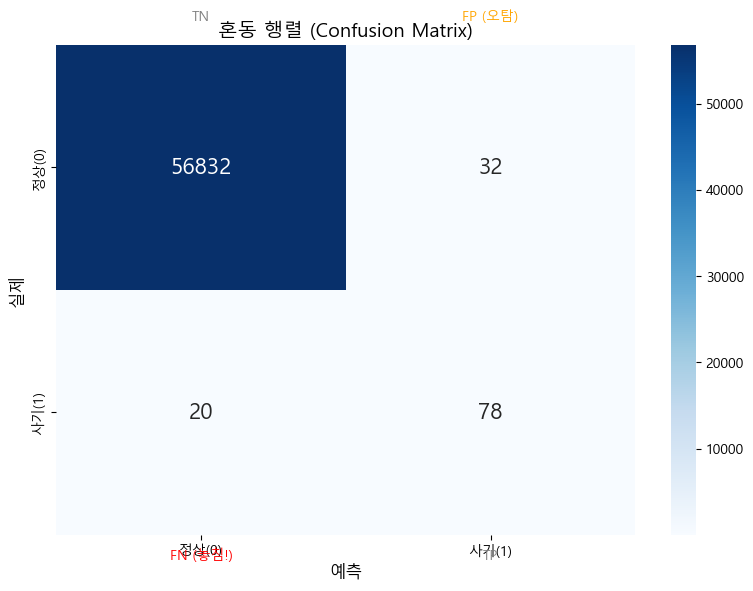

In [131]:
# 📚 혼동 행렬 시각화 (heatmap)

plt.figure(figsize=(8, 6))

# seaborn heatmap으로 시각화
sns.heatmap(
    cm, 
    annot=True,           # 숫자 표시
    fmt='d',              # 정수 형태
    cmap='Blues',         # 색상
    xticklabels=['정상(0)', '사기(1)'],
    yticklabels=['정상(0)', '사기(1)'],
    annot_kws={'size': 16}
)

plt.xlabel('예측', fontsize=12)
plt.ylabel('실제', fontsize=12)
plt.title('혼동 행렬 (Confusion Matrix)', fontsize=14)

# 각 셀에 의미 추가
plt.text(0.5, -0.1, 'TN', ha='center', fontsize=10, color='gray')
plt.text(1.5, -0.1, 'FP (오탐)', ha='center', fontsize=10, color='orange')
plt.text(0.5, 2.1, 'FN (놓침!)', ha='center', fontsize=10, color='red')
plt.text(1.5, 2.1, 'TP', ha='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

### 4-2. 평가 지표 상세

혼동 행렬에서 여러 평가 지표를 계산할 수 있습니다.

#### Accuracy (정확도)

**공식:** (TN + TP) / 전체 = 맞춘 개수 / 전체

```python
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
# y_test: 실제 정답
# y_pred: 모델 예측
```

**문제점:** 불균형 데이터에서 무의미!
- 사기 1%, 정상 99%인 경우
- "모두 정상"이라고 해도 정확도 99%
- 하지만 사기 탐지 못함 → 쓸모없는 모델

In [132]:
# 📚 accuracy_score

from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)

print("accuracy_score 사용:")
print(f"  accuracy_score(y_test, y_pred) = {acc:.4f}")
print(f"  → 전체 중 {acc:.1%} 맞춤")
print()

# 수동 계산으로 확인
manual_acc = (cm[0,0] + cm[1,1]) / cm.sum()
print(f"수동 계산: (TN + TP) / 전체 = ({cm[0,0]} + {cm[1,1]}) / {cm.sum()} = {manual_acc:.4f}")

accuracy_score 사용:
  accuracy_score(y_test, y_pred) = 0.9991
  → 전체 중 99.9% 맞춤

수동 계산: (TN + TP) / 전체 = (56832 + 78) / 56962 = 0.9991


#### Recall (재현율) - FDS 핵심!

**공식:** TP / (TP + FN) = 실제 사기 중 잡은 비율

```python
from sklearn.metrics import recall_score

rec = recall_score(y_test, y_pred)
```

**FDS에서 가장 중요한 지표:**
- Recall = 실제 사기 중 탐지 비율
- Recall이 낮으면 = 사기를 많이 놓침 = 돈 손해!
- **사기 100건 중 90건 잡으면 Recall = 90%**

In [133]:
# 📚 recall_score

from sklearn.metrics import recall_score

rec = recall_score(y_test, y_pred)

print("recall_score 사용:")
print(f"  recall_score(y_test, y_pred) = {rec:.4f}")
print(f"  → 실제 사기 중 {rec:.1%} 탐지")
print()

# 수동 계산으로 확인
TP = cm[1, 1]
FN = cm[1, 0]
manual_rec = TP / (TP + FN) if (TP + FN) > 0 else 0
print(f"수동 계산: TP / (TP + FN) = {TP} / ({TP} + {FN}) = {manual_rec:.4f}")

recall_score 사용:
  recall_score(y_test, y_pred) = 0.7959
  → 실제 사기 중 79.6% 탐지

수동 계산: TP / (TP + FN) = 78 / (78 + 20) = 0.7959


#### Precision (정밀도)

**공식:** TP / (TP + FP) = 사기라고 예측한 것 중 실제 사기 비율

```python
from sklearn.metrics import precision_score

prec = precision_score(y_test, y_pred)
```

**의미:**
- "사기입니다!"라고 예측했을 때, 진짜 사기인 비율
- Precision이 낮으면 = 오탐이 많음 = 정상 고객 불편

In [134]:
# 📚 precision_score

from sklearn.metrics import precision_score

prec = precision_score(y_test, y_pred)

print("precision_score 사용:")
print(f"  precision_score(y_test, y_pred) = {prec:.4f}")
print(f"  → 사기 예측 중 {prec:.1%}가 실제 사기")
print()

# 수동 계산으로 확인
TP = cm[1, 1]
FP = cm[0, 1]
manual_prec = TP / (TP + FP) if (TP + FP) > 0 else 0
print(f"수동 계산: TP / (TP + FP) = {TP} / ({TP} + {FP}) = {manual_prec:.4f}")

precision_score 사용:
  precision_score(y_test, y_pred) = 0.7091
  → 사기 예측 중 70.9%가 실제 사기

수동 계산: TP / (TP + FP) = 78 / (78 + 32) = 0.7091


#### AUC (Area Under Curve)

**주의:** 확률값(predict_proba)을 사용!

```python
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_proba[:, 1])  # 확률값 사용!
```

**의미:**
- 0.5 = 랜덤 (동전 던지기 수준)
- 1.0 = 완벽
- 0.7 이상이면 쓸만한 모델

In [135]:
# 📚 roc_auc_score

from sklearn.metrics import roc_auc_score

# 주의: predict가 아니라 predict_proba의 확률값 사용!
y_proba = model.predict_proba(X_test)
fraud_prob = y_proba[:, 1]  # 사기 확률

auc = roc_auc_score(y_test, fraud_prob)

print("roc_auc_score 사용:")
print(f"  roc_auc_score(y_test, fraud_prob) = {auc:.4f}")
print()
print("해석:")
print(f"  0.5 = 랜덤 수준")
print(f"  0.7 = 쓸만함")
print(f"  0.8 = 좋음")
print(f"  0.9 = 매우 좋음")
print(f"  현재: {auc:.2f}")

roc_auc_score 사용:
  roc_auc_score(y_test, fraud_prob) = 0.8977

해석:
  0.5 = 랜덤 수준
  0.7 = 쓸만함
  0.8 = 좋음
  0.9 = 매우 좋음
  현재: 0.90


In [136]:
# 📚 4개 지표 한눈에 보기

print("="*50)
print("평가 지표 요약")
print("="*50)
print(f"Accuracy:  {acc:.4f}  (전체 정확도)")
print(f"Recall:    {rec:.4f}  (사기 탐지율) ← FDS 핵심!")
print(f"Precision: {prec:.4f}  (사기 예측 정확도)")
print(f"AUC:       {auc:.4f}  (전체 성능)")

평가 지표 요약
Accuracy:  0.9991  (전체 정확도)
Recall:    0.7959  (사기 탐지율) ← FDS 핵심!
Precision: 0.7091  (사기 예측 정확도)
AUC:       0.8977  (전체 성능)


### 4-3. FDS에서 Recall이 중요한 이유

**비용 분석:**

| 오류 유형 | 비용 | 설명 |
|-----------|------|------|
| FN (사기 놓침) | **100만원** | 사기 거래 승인 → 손해 |
| FP (오탐) | 1,000원 | 정상 고객에게 전화 → 인건비 |

**비용 비율: FN:FP = 1000:1**

```
사기 100건 중:
- Recall 90% → 10건 놓침 → 1000만원 손해
- Recall 95% → 5건 놓침 → 500만원 손해
- Recall 5% 올리면 → 500만원 절약!

오탐 100건:
- 전화 100통 = 10만원 비용
```

**결론: Recall을 올리는 게 훨씬 이득!**

In [137]:
# 📚 비용 계산 예시

# 현재 혼동 행렬 값
TN, FP = cm[0, 0], cm[0, 1]
FN, TP = cm[1, 0], cm[1, 1]

# 비용 설정
cost_fn = 1000000  # 사기 놓침: 100만원
cost_fp = 1000     # 오탐: 1000원

# 총 비용 계산
total_cost = FN * cost_fn + FP * cost_fp

print("비용 분석:")
print("="*50)
print(f"FN (사기 놓침): {FN}건 × {cost_fn:,}원 = {FN * cost_fn:,}원")
print(f"FP (오탐):     {FP}건 × {cost_fp:,}원 = {FP * cost_fp:,}원")
print("-"*50)
print(f"총 비용: {total_cost:,}원")
print()
print("→ FN 1건 줄이면 100만원 절약!")
print("→ Recall이 중요한 이유")

비용 분석:
FN (사기 놓침): 20건 × 1,000,000원 = 20,000,000원
FP (오탐):     32건 × 1,000원 = 32,000원
--------------------------------------------------
총 비용: 20,032,000원

→ FN 1건 줄이면 100만원 절약!
→ Recall이 중요한 이유


### 💻 실습 3: 평가 지표 계산

RandomForest 모델(rf_model)의 평가 지표를 계산하세요.

In [138]:
# 💻 실습 3
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

# rf_pred, rf_proba는 실습 2에서 만든 것 사용
# 만약 실습 2를 안 했다면 아래 주석 해제
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)
# rf_pred = rf_model.predict(X_test)
# rf_proba = rf_model.predict_proba(X_test)[:, 1]

# TODO: 4개 지표 계산
rf_acc = accuracy_score(y_test, rf_pred)   # TODO: accuracy_score(y_test, rf_pred)
rf_rec = recall_score(y_test, rf_pred)   # TODO: recall_score(y_test, rf_pred)
rf_prec = precision_score(y_test, rf_pred)  # TODO: precision_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_proba[:,1])   # TODO: roc_auc_score(y_test, rf_proba)

print("RandomForest 평가 지표:")
print(f"  Accuracy:  {rf_acc:.4f}")
print(f"  Recall:    {rf_rec:.4f}")
print(f"  Precision: {rf_prec:.4f}")
print(f"  AUC:       {rf_auc:.4f}")

RandomForest 평가 지표:
  Accuracy:  0.9996
  Recall:    0.8061
  Precision: 0.9634
  AUC:       0.9528


In [66]:
# 체크포인트 3
assert rf_acc is not None, "Accuracy 계산 필요"
assert 0 <= rf_rec <= 1, "Recall은 0~1 사이"
assert 0 <= rf_auc <= 1, "AUC는 0~1 사이"

print("체크포인트 3 통과!")

체크포인트 3 통과!


---
## 5. 트리 모델 비교

### 5-1. Decision Tree (의사결정 트리)

**작동 원리:**
- "이 특성이 X 이상이면 왼쪽, 아니면 오른쪽"
- 질문을 반복해서 분류
- 마지막 노드(잎)에서 최종 결정

```python
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    max_depth=5,    # 트리 깊이 제한 (과적합 방지)
    random_state=42
)
```

IndexError: list index out of range

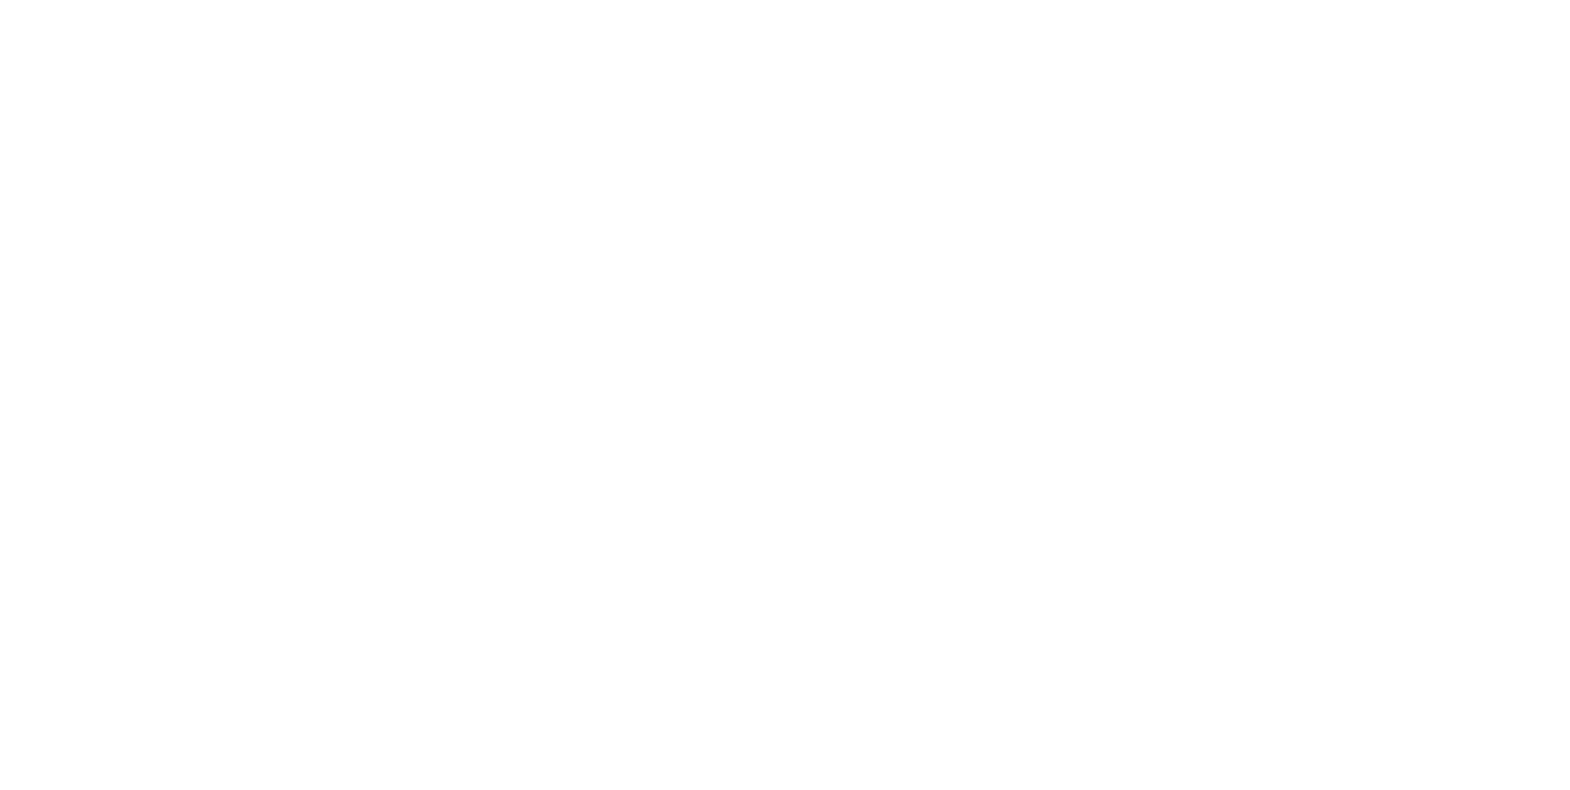

In [139]:
# 📚 Decision Tree 시각화

from sklearn.tree import DecisionTreeClassifier, plot_tree

# 시각화용으로 얕은 트리 학습
dt_viz = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_viz.fit(X_train, y_train)

# 트리 시각화
plt.figure(figsize=(20, 10))
plot_tree(
    dt_viz,
    feature_names=feature_cols[:3],
    class_names=['정상', '사기'],
    filled=True,           # 색상 채우기
    rounded=True,          # 둥근 모서리
    fontsize=10
)
plt.title('Decision Tree 시각화 (깊이 3)', fontsize=14)
plt.tight_layout()
plt.show()

print("해석:")
print("  - 각 노드는 '질문' (예: amount <= 50000)")
print("  - True면 왼쪽, False면 오른쪽")
print("  - 마지막 노드에서 class 결정")
print("  - 색이 진할수록 한 클래스가 많음")

#### Decision Tree 장단점 및 실제 사용

| 구분 | 내용 |
|------|------|
| **장점** | 해석 가능성 최고 (규칙 추출 가능), 시각화 가능, 전처리 거의 불필요 |
| **단점** | 성능 낮음, 과적합 쉬움, 불안정 (데이터 조금 바뀌면 트리 구조 크게 변함) |
| **실제 사용** | 규제 산업에서 "왜?" 설명 필요할 때, 데이터 탐색/이해, 빠른 프로토타입 |

```
예시: 금융 규제 기관에 보고할 때
"이 거래를 사기로 판단한 이유:
 1. 금액이 100만원 초과
 2. 새벽 3시 거래
 3. 해외 결제"
→ Decision Tree는 이런 규칙을 직접 추출 가능!
```

### 5-2. Random Forest (랜덤 포레스트)

**핵심 아이디어:** 여러 Decision Tree가 **투표**

```
트리1: "사기" ─┐
트리2: "정상" ─┼─→ 다수결: "사기" (2:1)
트리3: "사기" ─┘
```

**왜 좋은가?**
- 각 트리는 다른 데이터 샘플로 학습
- 개별 트리가 틀려도 다수결로 보완
- Decision Tree보다 안정적

```python
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    random_state=42
)
```

#### Random Forest 장단점 및 실제 사용

| 구분 | 내용 |
|------|------|
| **장점** | 튜닝 없이도 잘 작동, 과적합에 강함, 병렬처리 가능, 특성 중요도 제공 |
| **단점** | 메모리 사용 많음 (트리 100개 저장), XGBoost보다 성능 약간 낮음 |
| **실제 사용** | 베이스라인 모델, 빠른 개발/프로토타입, 튜닝 시간 없을 때 |

```
실무 흐름 예시:
1. Random Forest로 먼저 베이스라인 성능 측정 (AUC 0.85)
2. "이 정도면 충분한가?" 판단
3. 더 필요하면 XGBoost로 업그레이드 (AUC 0.88)
→ Random Forest는 "빠른 시작점" 역할
```

In [140]:
# 📚 Random Forest 예제

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,  # 100개의 트리
    random_state=42
)

rf.fit(X_train, y_train)

print("Random Forest 모델:")
print(f"  트리 개수: {rf.n_estimators}")
print(f"  특성 개수: {rf.n_features_in_}")
print()

# 특성 중요도
print("특성 중요도 (어떤 특성이 분류에 중요한가):")
for name, importance in zip(feature_cols, rf.feature_importances_):
    print(f"  {name}: {importance:.3f}")

Random Forest 모델:
  트리 개수: 100
  특성 개수: 15

특성 중요도 (어떤 특성이 분류에 중요한가):
  V1: 0.024
  V2: 0.022
  V3: 0.030
  V4: 0.049
  V5: 0.023
  V6: 0.030
  V7: 0.058
  V8: 0.029
  V9: 0.063
  V10: 0.136
  V11: 0.123
  V12: 0.185
  V13: 0.022
  V14: 0.185
  Amount: 0.019


#### XGBoost 장단점 및 실제 사용

| 구분 | 내용 |
|------|------|
| **장점** | 정형 데이터 성능 최고, 결측치 자동 처리, 정규화 내장, GPU 지원 |
| **단점** | 하이퍼파라미터 많음 (튜닝 복잡), 블랙박스 (직접 해석 어려움) |
| **실제 사용** | 최고 성능 필요할 때, Kaggle 대회, 프로덕션 FDS |

**그런데 블랙박스면 FDS에서 어떻게 쓰나?**

```
XGBoost 단독: "이 거래는 사기입니다" (왜?)
                    ↓
            SHAP 적용
                    ↓
XGBoost + SHAP: "이 거래는 사기입니다. 이유:
                 - 금액이 높아서 +35%
                 - 새벽 시간이라 +25%
                 - 해외 결제라서 +20%"
```

**→ 이 프로젝트의 핵심: XGBoost(성능) + SHAP(설명) 조합!**

### 5-3. XGBoost

**핵심 아이디어:** 이전 트리가 틀린 것에 **집중**해서 다음 트리 학습

```
트리1 학습 → 틀린 샘플 파악 → 트리2가 틀린 것 집중 학습 → ...
```

**Gradient Boosting:**
- 순차적으로 트리 추가
- 각 트리가 이전의 실수를 보완
- 성능 최고, FDS에서 가장 많이 사용

```python
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,      # 트리 개수
    eval_metric='logloss', # 경고 방지용
    random_state=42
)
```

In [141]:
# 📚 XGBoost 예제 (GPU 사용)
import time
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    device='cuda',
    eval_metric='logloss',
    random_state=42
)

start = time.time()
xgb.fit(X_train, y_train)
print(f"XGBoost 학습: {time.time() - start:.1f}초")

print(f"\n트리 개수: {xgb.n_estimators}")
print(f"scale_pos_weight: {scale_pos_weight:.1f}")

# 특성 중요도 (상위 5개)
importances = list(zip(feature_cols, xgb.feature_importances_))
importances.sort(key=lambda x: x[1], reverse=True)
print("\n특성 중요도 (상위 5개):")
for name, imp in importances[:5]:
    print(f"  {name}: {imp:.3f}")

XGBoost 학습: 1.3초

트리 개수: 100
scale_pos_weight: 577.3

특성 중요도 (상위 5개):
  V14: 0.688
  V4: 0.073
  V12: 0.047
  V7: 0.026
  V8: 0.025


### 🔥 CPU vs GPU 벤치마크

XGBoost는 GPU를 지원합니다. 28만건 데이터로 속도 차이를 직접 확인해보세요.

In [148]:
# 🔥 CPU vs GPU 속도 비교
import time
from xgboost import XGBClassifier

# CPU 테스트
print("CPU 테스트 중...")
cpu_model = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)
start = time.time()
cpu_model.fit(X_train, y_train)
cpu_time = time.time() - start
print(f"CPU 시간: {cpu_time:.2f}초")

# GPU 테스트 (CUDA 있을 때만)
try:
    print("GPU 테스트 중...")
    gpu_model = XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        device='cuda',  # GPU 사용
        eval_metric='logloss',
        random_state=42
    )
    start = time.time()
    gpu_model.fit(X_train, y_train)
    gpu_time = time.time() - start
    print(f"GPU 시간: {gpu_time:.2f}초")
    print(f"속도 향상: {cpu_time/gpu_time:.1f}배 빠름!")
except Exception as e:
    print(f"GPU 사용 불가: {e}")
    print("CUDA 설치 필요 또는 xgboost GPU 버전 필요")

CPU 테스트 중...
CPU 시간: 20.03초
GPU 테스트 중...
GPU 시간: 15.53초
속도 향상: 1.3배 빠름!


### 5-3.5 해석 가능성의 두 종류

ML 모델의 해석 가능성에는 두 가지 접근법이 있습니다:

#### 1. 내재적 해석 (Inherent Interpretability)
모델 자체가 규칙이라서 별도 도구 없이 직접 해석 가능

```
Decision Tree 예시:
금액 > 100만?
  ├─ Yes → 해외?
  │         ├─ Yes → 사기
  │         └─ No → 정상
  └─ No → 정상

→ 모델 = 규칙. 그냥 읽으면 됨!
```

#### 2. 사후 설명 (Post-hoc Explanation)
모델은 블랙박스지만, 별도 도구(SHAP)로 "왜?"를 설명

```
XGBoost: 복잡한 내부 구조 → 직접 해석 불가
             ↓
         SHAP 적용
             ↓
"이 거래가 사기로 판정된 이유:
 - 금액 높음: +35%
 - 새벽 시간: +25%
 - 해외 결제: +20%"
```

#### 이 프로젝트의 접근법

| 방식 | 성능 | 설명 가능성 |
|------|------|-------------|
| Decision Tree 단독 | 낮음 | 직접 해석 가능 |
| XGBoost 단독 | 높음 | 해석 불가 (블랙박스) |
| **XGBoost + SHAP** | **높음** | **SHAP으로 설명** ← 이 프로젝트! |

**→ 성능과 설명 가능성, 둘 다 잡는 방법!**

### 5-4. 3개 모델 비교

**트리 모델 진화:**

```
Decision Tree → Random Forest → XGBoost
   (단일 트리)    (여러 트리 투표)   (순차 보완)
```

| 모델 | 특징 | 성능 |
|------|------|------|
| Decision Tree | 단순, 해석 쉬움, 과적합 쉬움 | 보통 |
| Random Forest | 여러 트리 투표, 안정적 | 좋음 |
| XGBoost | 순차 보완, 성능 최고 | **최고** |

### 💻 실습 4: 3개 모델 비교

Decision Tree, Random Forest, XGBoost 성능을 비교하세요.

In [149]:
# 💻 실습 4: 3개 모델 비교
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, scale_pos_weight=scale_pos_weight,
                             device='cuda', eval_metric='logloss', random_state=42)
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Time': f"{train_time:.1f}s",
        'Accuracy': accuracy_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'Precision': precision_score(y_test, pred, zero_division=0),
        'AUC': roc_auc_score(y_test, proba)
    })
    print(f"{name}: {train_time:.1f}초")

print()
result_df = pd.DataFrame(results)
result_df

DecisionTree: 5.1초
RandomForest: 13.2초
XGBoost: 0.7초



C:\Users\82109\miniconda3\envs\fds\Lib\site-packages\xgboost\core.py:774: UserWarning: [04:34:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


,Model,Time,Accuracy,Recall,Precision,AUC
0,DecisionTree,5.1s,0.999087,0.795918,0.709091,0.897678
1,RandomForest,13.2s,0.999614,0.806122,0.963415,0.952814
2,XGBoost,0.7s,0.999456,0.826531,0.852632,0.975893


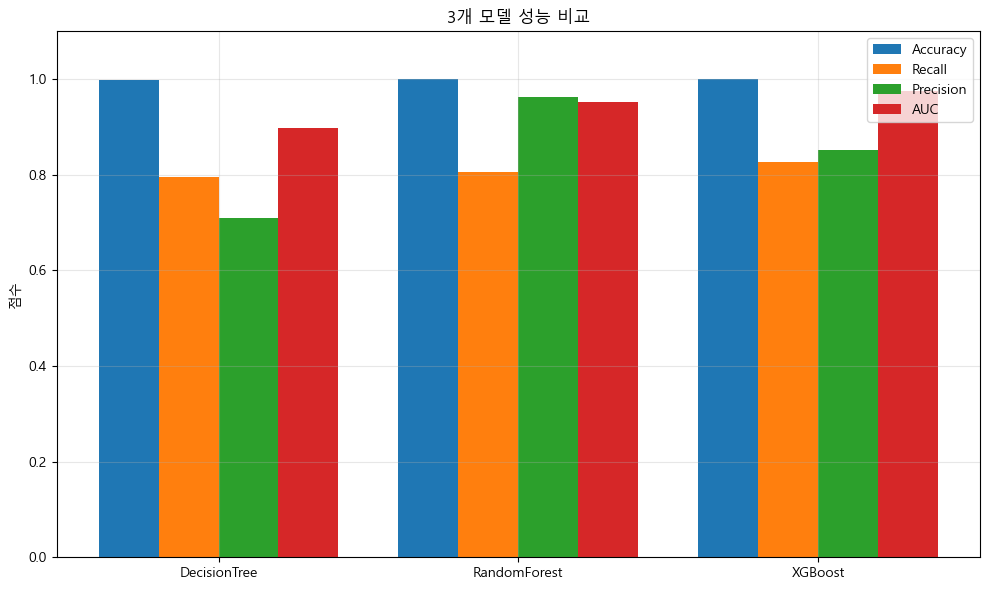

일반적으로: XGBoost >= RandomForest > DecisionTree


In [150]:
# 📚 모델 성능 비교 시각화

if len(result_df) == 3:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(result_df))
    width = 0.2
    
    bars1 = ax.bar(x - width*1.5, result_df['Accuracy'], width, label='Accuracy')
    bars2 = ax.bar(x - width*0.5, result_df['Recall'], width, label='Recall')
    bars3 = ax.bar(x + width*0.5, result_df['Precision'], width, label='Precision')
    bars4 = ax.bar(x + width*1.5, result_df['AUC'], width, label='AUC')
    
    ax.set_ylabel('점수')
    ax.set_title('3개 모델 성능 비교')
    ax.set_xticks(x)
    ax.set_xticklabels(result_df['Model'])
    ax.legend()
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("일반적으로: XGBoost >= RandomForest > DecisionTree")
else:
    print("모델 3개를 모두 완성해주세요!")

### 왜 현재 Recall이 낮은가?

위 결과에서 XGBoost Recall이 약 15%로 매우 낮습니다. **이건 정상입니다!**

#### 현재 데이터의 한계

```python
# 노트북의 데이터 생성 코드
fraud_prob = 0.01 + 0.05*(amount>100000) + 0.1*(새벽) + 0.1*(해외)
is_fraud = random() < fraud_prob  # ← 확률적으로 라벨 생성!
```

| 문제점 | 설명 |
|--------|------|
| 특성 3개뿐 | amount, hour, is_foreign만 사용 |
| 랜덤 라벨 | 같은 조건이어도 사기/정상 섞임 (노이즈) |
| 데이터 1000건 | ML 학습에 너무 적음 |
| 명확한 패턴 없음 | 모델이 학습할 수 있는 패턴이 약함 |

#### 실제 FDS 데이터와 비교

| 구분 | 노트북 (데모) | 실제 FDS |
|------|---------------|----------|
| 특성 수 | 3개 | 50~200개 |
| 데이터 | 1,000건 | 수백만 건 |
| 패턴 | 랜덤 노이즈 | 실제 사기 패턴 |
| Recall | ~15% | **90%+** |

#### Recall을 높이는 방법 (Phase 1에서 배울 것)

```python
# 1. Threshold 낮추기 (0.5 → 0.3)
pred = (proba > 0.3).astype(int)  # Recall ↑, Precision ↓

# 2. 클래스 가중치 (불균형 데이터 처리)
XGBClassifier(scale_pos_weight=9)  # 사기:정상 = 1:9 비율 보정

# 3. 더 많은 특성 사용
# 거래 패턴, 디바이스 정보, 위치 변화, 이전 거래 이력 등
```

**→ Phase 1에서 IEEE-CIS 실제 데이터로 XGBoost Recall 90%+ 달성 예정!**

In [151]:
# 체크포인트 4
assert len(result_df) == 3, "3개 모델 결과 필요"
assert 'XGBoost' in result_df['Model'].values, "XGBoost 포함 필요"

print("체크포인트 4 통과!")

체크포인트 4 통과!


---
## 최종 체크포인트

In [37]:
print("="*60)
print("  1-S1 완료: ML 개념 + Sklearn")
print("="*60)
print()
print("배운 것:")
print()
print("1. ML이란?")
print("   - 규칙 기반 한계 → ML로 자동 패턴 학습")
print("   - 분류 vs 회귀 (FDS = 이진 분류)")
print()
print("2. 과적합")
print("   - 학습 데이터만 잘 맞추고 새 데이터 실패")
print("   - train_test_split으로 방지")
print()
print("3. fit → predict 패턴")
print("   - fit(): 학습")
print("   - predict(): 0/1 예측")
print("   - predict_proba(): 확률 예측")
print()
print("4. 평가 지표")
print("   - 혼동 행렬: TN, FP, FN, TP")
print("   - Accuracy: 전체 정확도 (불균형에 무의미)")
print("   - Recall: 사기 탐지율 ← FDS 핵심!")
print("   - Precision: 예측 정확도")
print("   - AUC: 전체 성능")
print()
print("5. 트리 모델")
print("   - DecisionTree → RandomForest → XGBoost")
print("   - XGBoost: 성능 최고, FDS에서 주로 사용")
print()
print("="*60)
print("다음: 1-S2 모델 저장/튜닝/설명")
print("="*60)

  1-S1 완료: ML 개념 + Sklearn

배운 것:

1. ML이란?
   - 규칙 기반 한계 → ML로 자동 패턴 학습
   - 분류 vs 회귀 (FDS = 이진 분류)

2. 과적합
   - 학습 데이터만 잘 맞추고 새 데이터 실패
   - train_test_split으로 방지

3. fit → predict 패턴
   - fit(): 학습
   - predict(): 0/1 예측
   - predict_proba(): 확률 예측

4. 평가 지표
   - 혼동 행렬: TN, FP, FN, TP
   - Accuracy: 전체 정확도 (불균형에 무의미)
   - Recall: 사기 탐지율 ← FDS 핵심!
   - Precision: 예측 정확도
   - AUC: 전체 성능

5. 트리 모델
   - DecisionTree → RandomForest → XGBoost
   - XGBoost: 성능 최고, FDS에서 주로 사용

다음: 1-S2 모델 저장/튜닝/설명
